In [1]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [3]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [5]:
#initial preprocessing: drop 'ID' column, rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency 
data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [6]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [7]:
X_train.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [8]:
X_train_static = X_train[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']]
X_train_static

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
11018,160000,2,2,2,32
1710,100000,2,1,2,30
4618,80000,1,1,2,29
5482,20000,2,2,1,27
26187,50000,2,1,2,30
...,...,...,...,...,...
25780,200000,2,2,1,32
13921,120000,2,2,2,24
3794,120000,2,1,2,24
27565,360000,1,1,1,57


In [9]:
X_test_static = X_test[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE']]
X_test_static

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
8941,230000,1,2,2,30
17618,80000,2,1,1,32
27895,100000,2,1,2,29
16103,10000,2,2,1,37
4422,110000,2,2,1,34
...,...,...,...,...,...
27933,180000,2,2,2,25
26623,50000,1,2,2,25
21750,110000,2,2,2,24
14888,450000,2,1,3,37


In [10]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_static_encoded = pd.get_dummies(X_train_static, columns = ['EDUCATION','MARRIAGE'], drop_first = True)
cols_train_static = X_train_static_encoded.columns.tolist()

In [11]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_static_encoded = pd.get_dummies(X_test_static,columns = ['EDUCATION','MARRIAGE'], drop_first = True)
X_test_static_encoded = X_test_static_encoded.reindex(columns = cols_train_static).fillna(0)   #if unknown columns assign 0

In [12]:
numerical_static = ['LIMIT_BAL', 'AGE']

In [13]:
#Scaling numerical features
scaler2 = RobustScaler()

# Fit and transform the scaler on the training data
X_train_static_ready = copy.deepcopy(X_train_static_encoded)
X_train_static_ready[numerical_static] = scaler2.fit_transform(X_train_static_ready[numerical_static])

In [14]:
# Transform the test data using the fitted scaler
X_test_static_ready = copy.deepcopy(X_test_static_encoded)
X_test_static_ready[numerical_static] = scaler2.transform(X_test_static_ready[numerical_static])

In [15]:
#temporal features only
X_train_temp = X_train.drop(['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'],axis=1)
X_train_temp

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,0,0,0,0,0,0,156098,156259,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500
1710,0,0,0,0,2,0,28383,32903,42283,51539,50583,52588,5000,10000,10000,0,2846,1936
4618,0,0,0,0,0,0,73722,75323,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600
5482,0,0,-1,-1,-2,-2,7286,2160,780,0,0,0,1006,780,0,0,0,0
26187,-2,-2,-2,-2,-2,-2,0,2070,0,0,0,0,2070,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,0,0,-2,-2,-2,-2,10701,0,0,0,0,0,0,0,0,0,0,0
13921,0,0,0,0,0,2,112336,113351,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,0,0,0,0,0,0,75796,76004,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,1,-2,-1,-1,-1,-2,0,0,860,246,-46,-46,0,860,246,0,0,0


In [16]:
#numerical columns
numerical_cols = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [17]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_temp_scaled = copy.deepcopy(X_train_temp)
X_train_temp_scaled[numerical_cols] = scaler.fit_transform(X_train_temp_scaled[numerical_cols])

In [18]:
X_train_temp_scaled

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,0,0,0,0,0,0,2.106470,2.212479,2.362316,2.569009,2.859506,2.902562,0.965247,0.968526,0.897506,1.186631,1.179413,1.025641
1710,0,0,0,0,2,0,0.096888,0.194806,0.388584,0.622973,0.670019,0.743616,0.716568,1.940698,1.942637,-0.395544,0.351211,0.111795
4618,0,0,0,0,0,0,0.810292,0.888649,0.772334,0.506549,0.497744,0.538994,0.293814,0.117876,-0.063064,0.026370,0.024027,0.025641
5482,0,0,-1,-1,-2,-2,-0.235072,-0.308042,-0.335559,-0.363278,-0.373344,-0.356206,-0.276655,-0.300158,-0.432660,-0.395544,-0.396114,-0.384615
26187,-2,-2,-2,-2,-2,-2,-0.349716,-0.309514,-0.349169,-0.363278,-0.373344,-0.356206,-0.012061,-0.489731,-0.432660,-0.395544,-0.396114,-0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,0,0,-2,-2,-2,-2,-0.181337,-0.343372,-0.349169,-0.363278,-0.373344,-0.356206,-0.526826,-0.489731,-0.432660,-0.395544,-0.396114,-0.384615
13921,0,0,0,0,0,2,1.417880,1.510654,1.666334,1.817232,2.145738,2.194500,0.517625,0.506744,0.541211,2.241413,0.801287,-0.384615
3794,0,0,0,0,0,0,0.842926,0.899788,0.823108,0.592068,0.311216,0.058434,0.393286,0.001944,0.046200,0.131848,-0.081008,-0.128205
27565,1,-2,-1,-1,-1,-2,-0.349716,-0.343372,-0.334164,-0.358571,-0.374293,-0.357168,-0.526826,-0.280715,-0.374228,-0.395544,-0.396114,-0.384615


In [19]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [20]:
X_train_SMOTE = copy.deepcopy(X_train_temp_scaled)
y_train_SMOTE = copy.deepcopy(y_train)

In [21]:
X_train_static_SMOTE = copy.deepcopy(X_train_static_ready)

In [22]:
X_train_static

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
11018,160000,2,2,2,32
1710,100000,2,1,2,30
4618,80000,1,1,2,29
5482,20000,2,2,1,27
26187,50000,2,1,2,30
...,...,...,...,...,...
25780,200000,2,2,1,32
13921,120000,2,2,2,24
3794,120000,2,1,2,24
27565,360000,1,1,1,57


In [23]:
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [24]:
#3 temporal features in reverse column order (April to September)
PAY_smote = X_train_SMOTE.iloc[:,5::-1]
BILL_AMT_smote = X_train_SMOTE.iloc[:,11:5:-1]
PAY_AMT_smote = X_train_SMOTE.iloc[:,:11:-1]

PAY_smote = PAY_smote.to_numpy()
BILL_AMT_smote = BILL_AMT_smote.to_numpy()
PAY_AMT_smote = PAY_AMT_smote.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked_smote = np.dstack((PAY_smote,BILL_AMT_smote,PAY_AMT_smote))

y_train_SMOTE_array = y_train_SMOTE.to_numpy()

In [25]:
#3 temporal features in reverse column order (April to September)
PAY = X_train_temp_scaled.iloc[:,5::-1]
BILL_AMT = X_train_temp_scaled.iloc[:,11:5:-1]
PAY_AMT = X_train_temp_scaled.iloc[:,:11:-1]

In [26]:
PAY = PAY.to_numpy()
BILL_AMT = BILL_AMT.to_numpy()
PAY_AMT = PAY_AMT.to_numpy()

In [27]:
#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked = np.dstack((PAY,BILL_AMT,PAY_AMT))

In [28]:
stacked.shape

(21000, 6, 3)

In [29]:
y_train_array = y_train.to_numpy()

In [30]:
X_test_temp = X_test.drop(['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE'],axis=1)

In [31]:
X_test_temp

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
8941,0,0,0,0,0,0,101832,92396,84297,49681,46224,44800,5000,4000,2029,2000,2500,1300
17618,-1,3,2,-1,0,0,4927,4693,3342,4844,3728,2612,0,0,4844,0,0,0
27895,0,0,0,0,0,0,167410,85536,77303,60178,56436,51773,70001,3769,2008,1950,2001,18000
16103,-1,4,3,2,2,2,3305,2870,2440,2510,2641,2222,0,0,500,400,0,36
4422,0,0,0,0,0,0,24147,25750,27012,27762,32126,37779,2000,2000,1500,5000,6400,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27933,0,0,0,0,0,0,177607,177498,176081,175540,142015,139162,6500,7000,7200,5018,5200,5300
26623,0,0,0,0,0,0,11669,12665,12905,13498,13993,13854,1502,1522,1505,1000,1000,1000
21750,0,0,-1,-1,-1,-1,6071,0,3308,2527,1076,1164,0,3308,2527,1079,1167,1974
14888,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
# Transform the test data using the fitted scaler
X_test_temp_scaled = copy.deepcopy(X_test_temp)
X_test_temp_scaled[numerical_cols] = scaler.transform(X_test_temp_scaled[numerical_cols])

In [33]:
X_test_temp_scaled

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
8941,0,0,0,0,0,0,1.252600,1.167904,1.121643,0.587418,0.580107,0.580738,0.716568,0.482440,0.049287,0.131848,0.260356,-0.051282
17618,-1,3,2,-1,0,0,-0.272190,-0.266611,-0.290858,-0.270583,-0.296448,-0.301579,-0.526826,-0.489731,0.717933,-0.395544,-0.396114,-0.384615
27895,0,0,0,0,0,0,2.284463,1.055698,0.999612,0.788289,0.790747,0.726571,16.880945,0.426297,0.044299,0.118663,0.129324,4.230769
16103,-1,4,3,2,2,2,-0.297712,-0.296429,-0.306596,-0.315247,-0.318869,-0.309735,-0.526826,-0.489731,-0.313895,-0.290065,-0.396114,-0.375385
4422,0,0,0,0,0,0,0.030235,0.077808,0.122136,0.167976,0.289311,0.433901,-0.029468,-0.003646,-0.076366,0.922935,1.284448,-0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27933,0,0,0,0,0,0,2.444912,2.559875,2.723088,2.995857,2.555963,2.554219,1.089587,1.211569,1.277553,0.927681,0.969343,0.974359
26623,0,0,0,0,0,0,-0.166105,-0.136217,-0.124003,-0.104980,-0.084714,-0.066464,-0.153311,-0.119820,-0.075178,-0.131848,-0.133526,-0.128205
21750,0,0,-1,-1,-1,-1,-0.254189,-0.343372,-0.291451,-0.314921,-0.351150,-0.331862,-0.526826,0.314254,0.167577,-0.111016,-0.089674,0.121538
14888,1,-2,-2,-2,-2,-2,-0.349716,-0.343372,-0.349169,-0.363278,-0.373344,-0.356206,-0.526826,-0.489731,-0.432660,-0.395544,-0.396114,-0.384615


In [34]:
#3 temporal features in reverse column order (April to September)
PAY_test = X_test_temp_scaled.iloc[:,5::-1]
BILL_AMT_test = X_test_temp_scaled.iloc[:,11:5:-1]
PAY_AMT_test = X_test_temp_scaled.iloc[:,:11:-1]

In [35]:
PAY_test = PAY_test.to_numpy()
BILL_AMT_test = BILL_AMT_test.to_numpy()
PAY_AMT_test = PAY_AMT_test.to_numpy()

In [36]:
#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked_test = np.dstack((PAY_test,BILL_AMT_test,PAY_AMT_test))

In [37]:
y_test_array = y_test.to_numpy()

SO X_train = stacked, X_test = stacked_test, y_train = y_train_array, y_test = y_test_array

In [38]:
num_time_steps, num_features = stacked.shape[1], stacked.shape[2]

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(num_time_steps, num_features)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32

model.fit(stacked, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array))

# Evaluate the model
loss, accuracy = model.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')



Epoch 1/10
657/657 [==============================] - 7s 7ms/step - loss: 0.4635 - accuracy: 0.8019 - val_loss: 0.4506 - val_accuracy: 0.8067
Epoch 2/10
657/657 [==============================] - 4s 5ms/step - loss: 0.4426 - accuracy: 0.8137 - val_loss: 0.4409 - val_accuracy: 0.8093
Epoch 3/10
657/657 [==============================] - 3s 5ms/step - loss: 0.4377 - accuracy: 0.8169 - val_loss: 0.4420 - val_accuracy: 0.8120
Epoch 4/10
657/657 [==============================] - 3s 5ms/step - loss: 0.4350 - accuracy: 0.8207 - val_loss: 0.4391 - val_accuracy: 0.8164
Epoch 5/10
657/657 [==============================] - 4s 6ms/step - loss: 0.4342 - accuracy: 0.8206 - val_loss: 0.4383 - val_accuracy: 0.8172
Epoch 6/10
657/657 [==============================] - 4s 6ms/step - loss: 0.4324 - accuracy: 0.8216 - val_loss: 0.4382 - val_accuracy: 0.8170
Epoch 7/10
657/657 [==============================] - 3s 5ms/step - loss: 0.4317 - accuracy: 0.8226 - val_loss: 0.4371 - val_accuracy: 0.8153
Epoch 

In [40]:
# Make predictions on the test set
y_pred_probs = model.predict(stacked_test)
y_pred = (y_pred_probs>=0.5).astype(int)


282/282 [==============================] - 1s 2ms/step


In [41]:
print('Accuracy:', accuracy_score(y_test_array,y_pred))
print('Precision:', precision_score(y_test_array,y_pred))
print('Recall:', recall_score(y_test_array,y_pred))
print('F1 score:', f1_score(y_test_array,y_pred))

Accuracy: 0.8171111111111111
Precision: 0.6552655265526552
Recall: 0.3656454043194375
F1 score: 0.4693745970341715


Without scaling:

Accuracy: 0.7788888888888889

Precision: 0.6

Recall: 0.0015067805123053742

F1 score: 0.0030060120240480966

With scaling:

Accuracy: 0.8168888888888889

Precision: 0.6622516556291391

Recall: 0.3515821195379206

F1 score: 0.45931758530183725

SMOTE


In [42]:
stacked_smote.shape

(19626, 6, 3)

In [43]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,160000,2,2,2,32,0,0,0,0,0,...,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500
1710,100000,2,1,2,30,0,0,0,0,2,...,42283,51539,50583,52588,5000,10000,10000,0,2846,1936
4618,80000,1,1,2,29,0,0,0,0,0,...,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600
5482,20000,2,2,1,27,0,0,-1,-1,-2,...,780,0,0,0,1006,780,0,0,0,0
26187,50000,2,1,2,30,-2,-2,-2,-2,-2,...,0,0,0,0,2070,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,200000,2,2,1,32,0,0,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
13921,120000,2,2,2,24,0,0,0,0,0,...,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,120000,2,1,2,24,0,0,0,0,0,...,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,360000,1,1,1,57,1,-2,-1,-1,-1,...,860,246,-46,-46,0,860,246,0,0,0


In [44]:
num_time_steps2, num_features2 = stacked_smote.shape[1], stacked_smote.shape[2]


# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(64, input_shape=(num_time_steps2, num_features2)))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32

model2.fit(stacked_smote, y_train_SMOTE_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array))

# Evaluate the model
loss2, accuracy2 = model2.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss2:.4f}')
print(f'Test Accuracy: {accuracy2:.4f}')

# Make predictions on the test set
y_pred_probs2 = model2.predict(stacked_test)
y_pred2 = (y_pred_probs2>=0.5).astype(int)

Epoch 1/10
614/614 [==============================] - 5s 6ms/step - loss: 0.5474 - accuracy: 0.7399 - val_loss: 0.4794 - val_accuracy: 0.8033
Epoch 2/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5260 - accuracy: 0.7629 - val_loss: 0.4779 - val_accuracy: 0.8008
Epoch 3/10
614/614 [==============================] - 4s 6ms/step - loss: 0.5221 - accuracy: 0.7658 - val_loss: 0.4582 - val_accuracy: 0.8076
Epoch 4/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5191 - accuracy: 0.7655 - val_loss: 0.4604 - val_accuracy: 0.8077
Epoch 5/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5177 - accuracy: 0.7646 - val_loss: 0.4670 - val_accuracy: 0.8063
Epoch 6/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5151 - accuracy: 0.7648 - val_loss: 0.4818 - val_accuracy: 0.7970
Epoch 7/10
614/614 [==============================] - 3s 6ms/step - loss: 0.5141 - accuracy: 0.7678 - val_loss: 0.4601 - val_accuracy: 0.8103
Epoch 

In [45]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,473
Trainable params: 17,473
Non-trainable params: 0
_________________________________________________________________


In [46]:
print('Accuracy:', accuracy_score(y_test_array,y_pred2))
print('Precision:', precision_score(y_test_array,y_pred2))
print('Recall:', recall_score(y_test_array,y_pred2))
print('F1 score:', f1_score(y_test_array,y_pred2))

Accuracy: 0.8078888888888889
Precision: 0.5865257595772787
Recall: 0.44600703164239075
F1 score: 0.5067047075606276


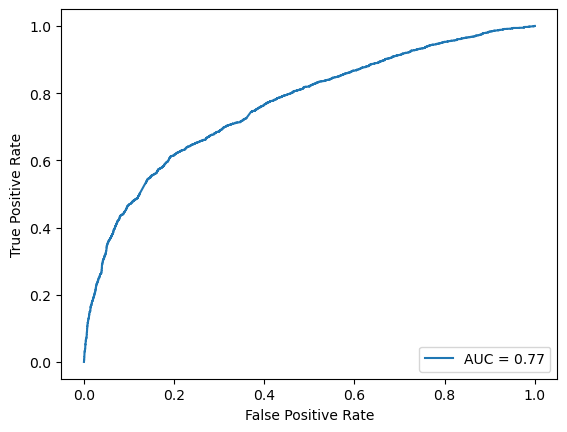

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_array, y_pred_probs2)

# Calculate the AUC score
auc_score = roc_auc_score(y_test_array, y_pred_probs2)

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
roc_display.plot()
plt.show()